# Bellezza, sesso e potere {#sec-regression-beauty}

**Prerequisiti**

- Leggere *Regression and Other Stories* [@gelman2020regression].
  - Prestare particolare attenzione al Capitolo 9, "Prediction and Bayesian Inference", che discute in dettaglio l'utilità di includere informazioni aggiuntive nel modello utilizzando una distribuzione a priori.

**Concetti e Competenze Chiave**

- 

**Preparazione del Notebook**

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
from IPython import get_ipython
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
import pingouin as pg
from sklearn.linear_model import LinearRegression

In [2]:
seed: int = sum(map(ord, "beauty_sex_power"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory
project_directory = os.path.join(home_directory, "_repositories", "psicometria")

def standardize(series):
    """Standardize a pandas series with n degrees of freedom"""
    return (series - series.mean()) / series.std(ddof=0)

## Introduzione {.unnumbered}

@gelman2009beauty discutono le difficoltà statistiche che emergono nell'analizzare piccoli campioni di dati. Uno degli studi che esaminano è quello di @kanazawa2007beautiful, in cui l'autore propone che i genitori con tratti ereditari che aumentano il successo riproduttivo maschile più di quello femminile in un dato ambiente avranno una proporzione di figli maschi superiore al previsto. Al contrario, i genitori con tratti ereditari che favoriscono maggiormente il successo riproduttivo femminile rispetto a quello maschile avranno una proporzione di figlie superiore al previsto. Kanazawa identifica l'attrattività fisica come un tratto ereditario che aumenta significativamente il successo riproduttivo delle figlie più di quello dei figli. Pertanto, prevede che i genitori fisicamente attraenti avranno una proporzione di figlie superiore al previsto. Inoltre, se l'attrattività è ereditaria e i genitori attraenti hanno più figlie, nel corso dell'evoluzione le donne dovrebbero diventare gradualmente più attraenti degli uomini. Secondo @kanazawa2007beautiful, l'analisi dei dati della National Longitudinal Study of Adolescent Health (Add Health) conferma entrambe queste ipotesi: gli individui molto attraenti hanno il 26% di probabilità in meno di avere un figlio maschio, e le donne risultano significativamente più attraenti degli uomini nel campione rappresentativo americano.

## Lo Studio di @@kanazawa2007beautiful

L'attrattività è stata misurata su una scala da 1 a 5 (“molto poco attraente” a “molto attraente”). @gelman2009beauty si concentrano su questo risultato riportato da @kanazawa2007beautiful:

> If I dichotomize the respondents into those who are rated ‘‘very attractive’’ and everyone else, the difference in the proportion of sons between the two groups (0.52 vs. 0.44) is statistically significant (t = 2.44, p $\geq$ 0.05). There appears to be something qualitatively different about respondents rated "very attractive".

In altre parole:

- il 56% dei figli di genitori nella categoria 5 erano femmine;
- il 48% dei figli di genitori nelle categorie da 1 a 4 erano femmine.

Questo risultato risulta 'statisticamente significativo'.

@gelman2009beauty fanno notare come la dicotomizzazione proposta da @kanazawa2007beautiful sia arbitraria. La variabile indipendente ha 5 livelli e sono possibili quattro confronti tra i livelli. @kanazawa2007beautiful ha scelto arbitariamente uno di questi confronti.

È dunque più naturale esaminare tutti i dati mediante un modello di regressione. I dati sono i seguenti:

In [22]:
x = np.arange(-2, 3, 1)
y = np.array([50, 44, 50, 47, 56])
sexratio = pd.DataFrame({"x": x, "y": y})
sexratio

,x,y
0,-2,50
1,-1,44
2,0,50
3,1,47
4,2,56


Per comodità, le cinque categorie della $X$ sono state ricodificate in modo tale che la categoria centrale abbia valore 0.

In [23]:
# Calcolo dei prior Bayesiani
theta_hat_prior = 0
se_prior = 0.25
theta_hat_data = 8
se_data = 3
theta_hat_bayes = (theta_hat_prior / se_prior**2 + theta_hat_data / se_data**2) / (
    1 / se_prior**2 + 1 / se_data**2
)
se_bayes = np.sqrt(1 / (1 / se_prior**2 + 1 / se_data**2))

In [25]:
# Regressione lineare con Pingouin
fm = pg.linear_regression(sexratio[["x"]], sexratio["y"])
fm.round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,49.4,1.9442,25.4086,0.0001,0.2841,0.0455,43.2126,55.5874
1,x,1.5,1.3748,1.0911,0.3550,0.2841,0.0455,-2.8751,5.8751


/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_32471/3465279703.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


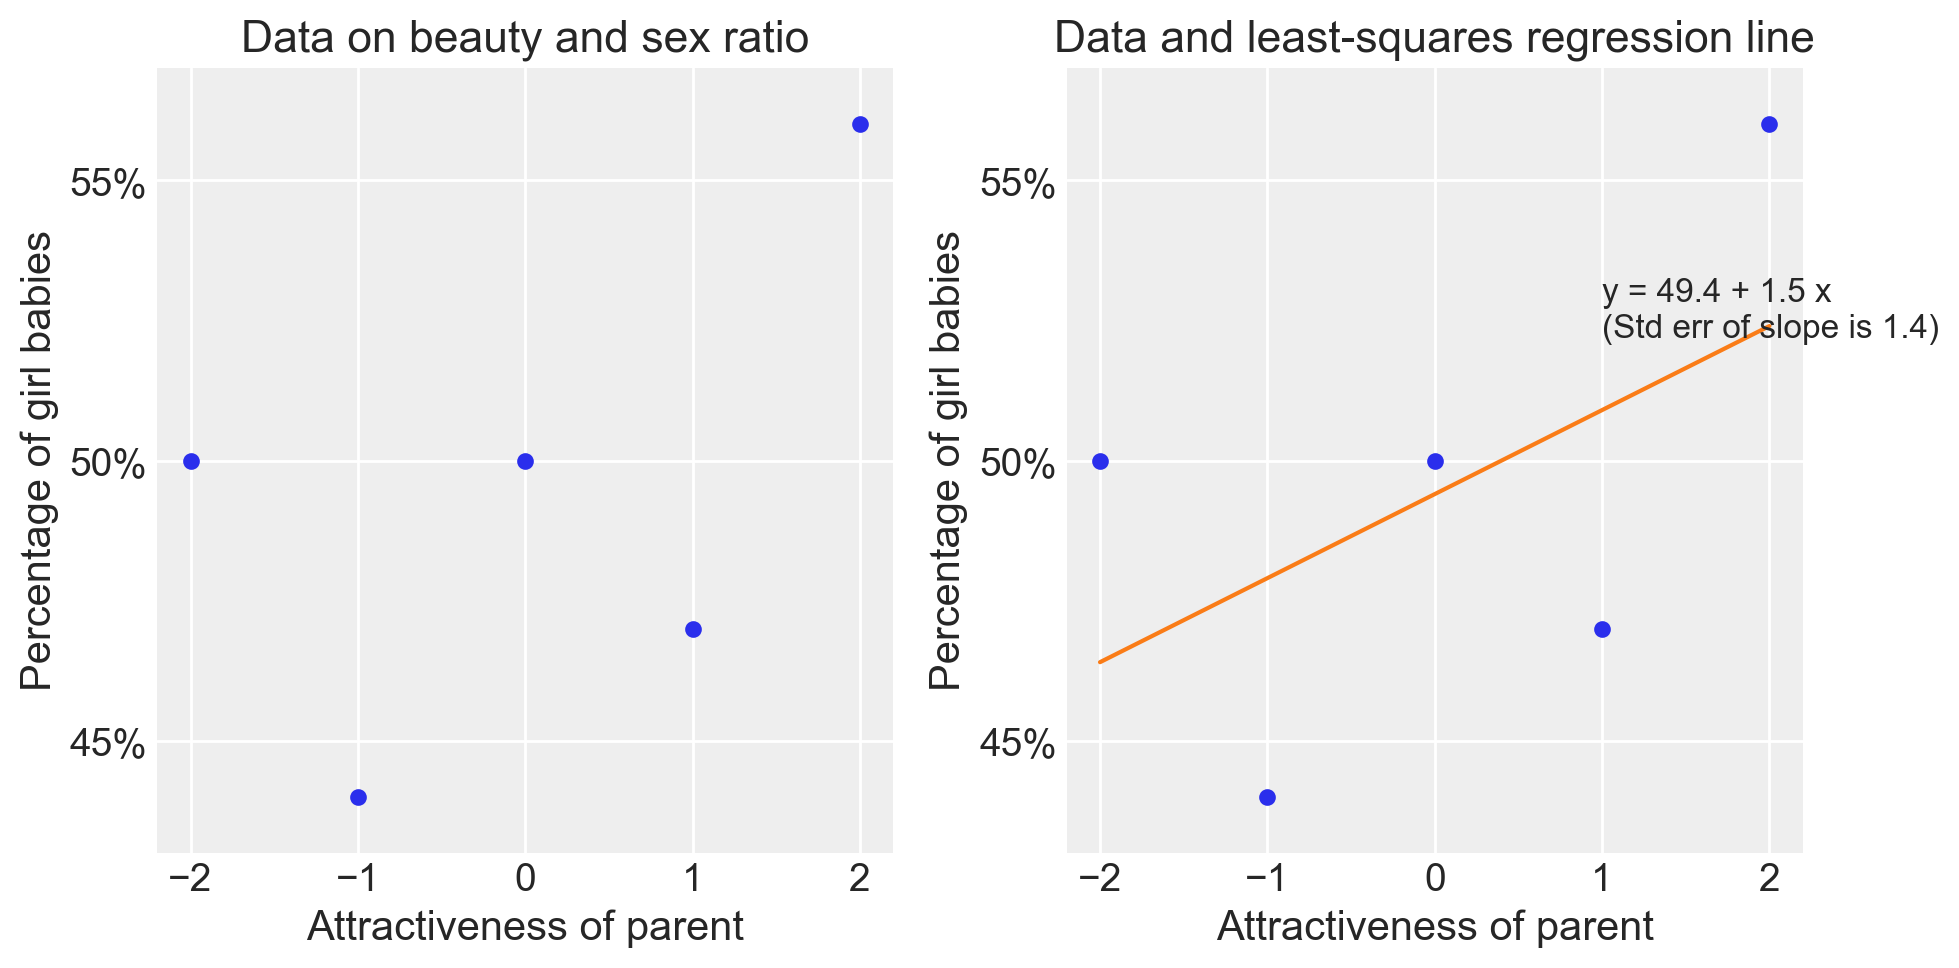

In [26]:
# Plot dei dati e della linea di regressione
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, "o", markersize=5)
plt.ylim(43, 57)
plt.xlabel("Attractiveness of parent")
plt.ylabel("Percentage of girl babies")
plt.title("Data on beauty and sex ratio")
plt.yticks([45, 50, 55], [f"{i}%" for i in [45, 50, 55]])

plt.subplot(1, 2, 2)
plt.plot(x, y, "o", markersize=5)
plt.ylim(43, 57)
plt.xlabel("Attractiveness of parent")
plt.ylabel("Percentage of girl babies")
plt.title("Data and least-squares regression line")
plt.yticks([45, 50, 55], [f"{i}%" for i in [45, 50, 55]])
slope, intercept = fm["coef"].values[1], fm["coef"].values[0]
plt.plot(x, intercept + slope * x, "-")
plt.text(
    1,
    52.2,
    f"y = {intercept:.1f} + {slope:.1f} x\n(Std err of slope is {fm['se'].values[1]:.1f})",
)

plt.tight_layout()
plt.show()

## Analisi Bayesiana con Prior Non Informativi

Mediante l'utilizzo di prior non informativi ci possiamo aspettare che l'analisi bayesisana sostanzialmente replichi il risultato dell'analisi frequentista.

Sistemiamo i dati nel formato richiesto da Stan.

In [27]:
stan_data = {"N": len(sexratio), "x": sexratio["x"].values, "y": sexratio["y"].values}
stan_data

{'N': 5, 'x': array([-2, -1,  0,  1,  2]), 'y': array([50, 44, 50, 47, 56])}

Formuliamo il modello di regressione bivariata utilizzando prior non informativi.

In [28]:
stan_file = os.path.join(project_directory, 'stan', 'sex_ratio.stan')
model1 = CmdStanModel(stan_file=stan_file)
print(model1.code())

data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
}



Eseguiamo il campionamento MCMC.

In [29]:
fit1 = model1.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le distribuzioni a posteriori dei parametri.

In [30]:
az.summary(fit1, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,49.512,6.228,39.278,58.560,0.103,0.081,3384.0,1640.0,1.0
beta,1.543,4.567,-5.028,8.927,0.088,0.104,3851.0,1381.0,1.0
sigma,9.406,10.183,2.109,22.019,0.357,0.252,912.0,1188.0,1.0


La soluzione ottenuta replica quella del metodo dei minimi quadrati. In entrambi i casi, sia l'intervallo di confidenza che l'intervallo credibile includono lo zero, il che indica che l'attrattività dei genitori non sembra avere un effetto credibile sulla proporzione di nascite femminili. Tuttavia, nonostante la notevole incertezza, l'analisi mostra che il coefficiente $\beta$ è positivo e pari a 1.5.

## Analisi Bayesiana con Prior Debolmente Informativi

@gelman2009beauty propongono l'uso di *prior debolmente informativi* nel contesto di un'analisi sulla relazione tra l'attrattività dei genitori e la percentuale di nascite femminili. Questi prior sono basati su informazioni precedenti e su ipotesi ragionevoli relative al problema studiato. Ecco come vengono definiti i due principali coefficienti del modello di regressione:

1. **Intercetta (a):**
   - La variabile intercetta rappresenta la percentuale di nascite femminili quando l'attrattività dei genitori è nella media.
   - @gelman2009beauty utilizzano una distribuzione normale centrata a 48.8 con una deviazione standard di 0.5. Questo indica che, sulla base dei dati esistenti, ci si aspetta che la percentuale di nascite femminili per genitori con attrattività media sia circa il 48.8%, con un margine di variazione di ±0.5%. Questo valore è scelto perché, in generale, la percentuale di nascite femminili è stabile tra il 48.5% e il 49%.

2. **Coefficiente angolare (b):**
   - Il coefficiente angolare rappresenta l'effetto dell'attrattività dei genitori sulla percentuale di nascite femminili.
   - @gelman2009beauty scelgono una distribuzione normale centrata a 0 con una deviazione standard di 0.2. Questo riflette l'assenza di una forte convinzione a priori che l'attrattività sia correlata in modo robusto con il sesso del neonato. Il valore della deviazione standard di 0.2 indica che ci si aspetta che il coefficiente possa variare tra -0.2 e 0.2. Dato che la variabile predittiva (l'attrattività) ha un intervallo di 4 punti, questa scelta implica che l'effetto massimo atteso dell'attrattività sulla percentuale di nascite femminili sia di ±0.8 punti percentuali, confrontando la categoria di attrattività più alta con quella più bassa.

Questi *prior debolmente informativi* aiutano a guidare l'analisi, integrando l'informazione che la percentuale di nascite femminili è molto stabile e suggerendo che, se c'è un effetto dell'attrattività, esso è probabile che sia piuttosto piccolo.

Compiliamo e stampiamo il modello che include i prior debolmente informativi.

In [31]:
stan_file_ip = os.path.join(project_directory, "stan", "sex_ratio_informative_prior.stan")
model2 = CmdStanModel(stan_file=stan_file_ip)
print(model2.code())

data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(48.8, 0.5);
  beta ~ normal(0, 0.2);
  y ~ normal(alpha + beta * x, sigma);
}



Eseguiamo il campionamento.

In [32]:
fit2 = model2.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori.

In [33]:
az.summary(fit2, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,48.828,0.487,47.879,49.715,0.006,0.004,6402.0,5373.0,1.0
beta,0.028,0.201,-0.352,0.395,0.002,0.002,7334.0,5464.0,1.0
sigma,5.696,3.290,2.294,10.366,0.060,0.049,6248.0,3964.0,1.0


Si osserva che, quando vengono utilizzati prior debolmente informativi, l'effetto dell'attrattività dei genitori risulta sostanzialmente nullo.

I due grafici seguenti mostrano la variabilità della retta di regressione stimata dal modello bayesiano sia con prior non informativi che con prior informativi. Nel caso di prior non informativi, nonostante l'ampia variabilità nella stima della pendenza della retta di regressione, emerge una lieve coerenza che suggerisce una relazione positiva molto debole. Al contrario, con prior debolmente informativi, la pendenza della retta di regressione stimata dal modello bayesiano risulta chiaramente piatta, eliminando qualsiasi incertezza.

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_32471/2498333150.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


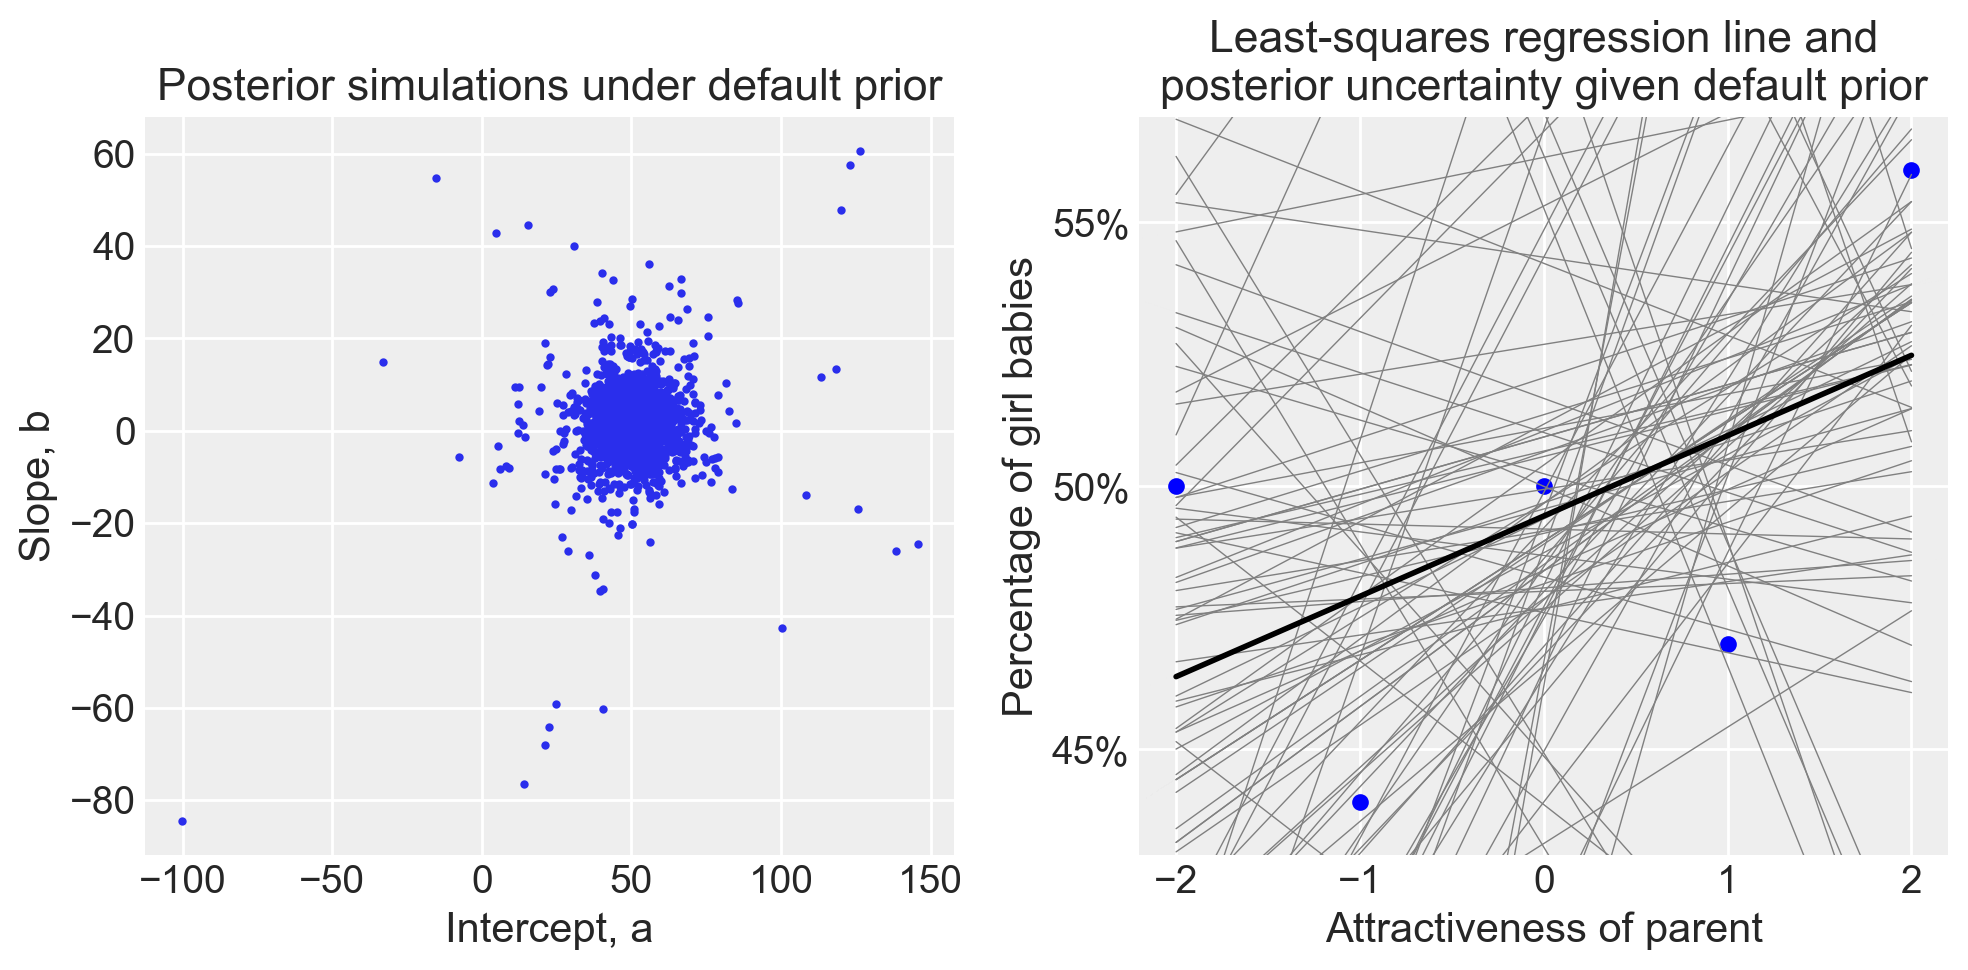

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_32471/2498333150.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


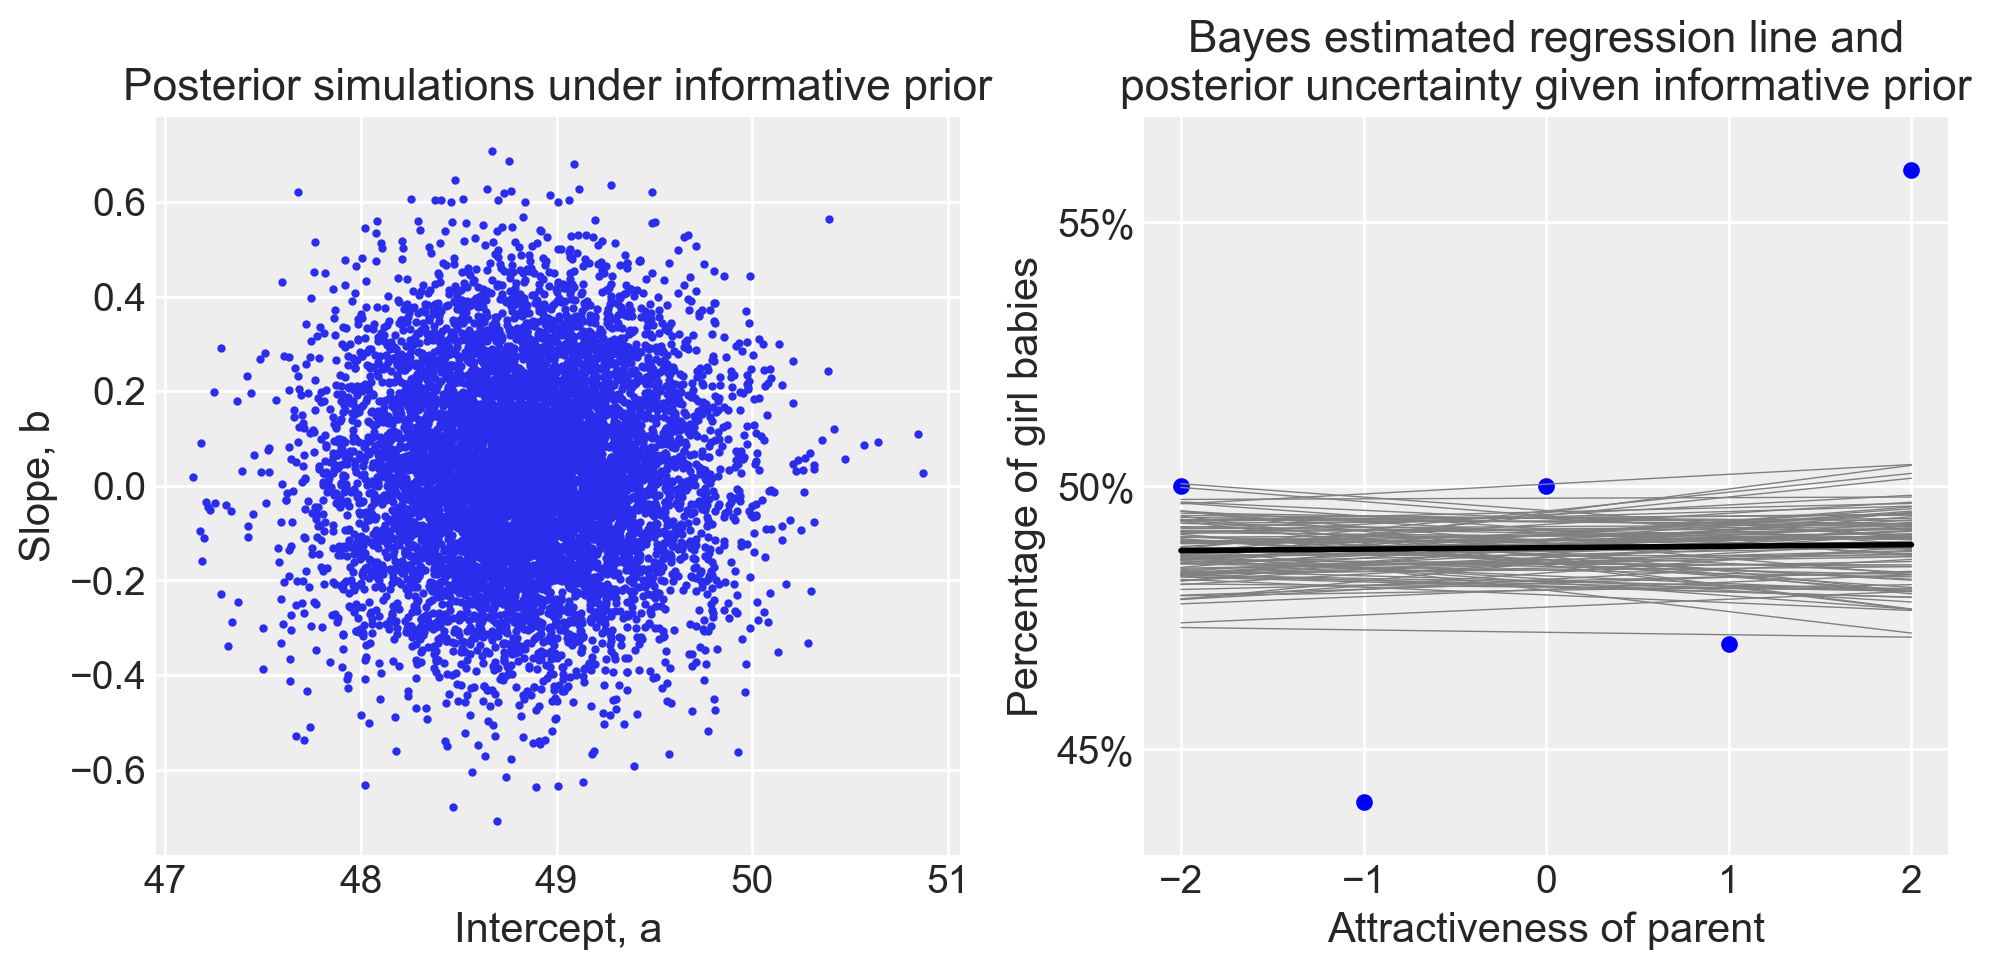

In [34]:
# Analisi dei risultati
fit_bayes = [fit1, fit2]

for k, fit in enumerate(fit_bayes):
    sims = fit.draws_pd()
    coef_est = sims.median()
    b_se = 1.483 * np.median(np.abs(sims["beta"] - coef_est["beta"]))

    plt.figure(figsize=(10, 5))

    # Plot delle simulazioni posteriori
    plt.subplot(1, 2, 1)
    plt.plot(sims["alpha"], sims["beta"], "o", markersize=2)
    plt.xlabel("Intercept, a")
    plt.ylabel("Slope, b")
    plt.title(
        f"Posterior simulations under {'default prior' if k == 0 else 'informative prior'}"
    )

    # Plot dei dati grezzi e della linea di regressione
    plt.subplot(1, 2, 2)
    plt.plot(x, y, "o", color="blue", markersize=5)  
    plt.ylim(43, 57)
    plt.xlabel("Attractiveness of parent")
    plt.ylabel("Percentage of girl babies")
    plt.title(
        f"{'Least-squares regression line and\nposterior uncertainty given default prior' if k == 0 else 'Bayes estimated regression line and\nposterior uncertainty given informative prior'}"
    )
    plt.yticks([45, 50, 55], [f"{i}%" for i in [45, 50, 55]])

    # Aggiunta delle linee di regressione dai campioni posteriori
    for i in range(100):
        plt.plot(
            x, sims["alpha"].iloc[i] + sims["beta"].iloc[i] * x, color="gray", lw=0.5
        )

    # Linea di regressione basata sui valori mediani stimati
    plt.plot(x, coef_est["alpha"] + coef_est["beta"] * x, color="black", lw=2)

    plt.tight_layout()
    plt.show()

## Considerazioni Conclusive

L'analisi delle relazioni tra bellezza e proporzione di nascite femminili nei campioni di piccole dimensioni mette in luce l'importanza di considerare la potenza statistica e l'uso di prior informativi nei modelli statistici. In studi con campioni ridotti, c'è un rischio notevole di ottenere risultati che, pur sembrando indicativi di un effetto, sono in realtà frutto del caso e non rappresentano una realtà sottostante. Questo fenomeno è reso più insidioso dall'attuale pratiche delle pubblicazioni scientifiche che molto spesso selezionano gli studi da pubblicare solo sulla presenza di effetti "statisticamente significativi", e che tendono a favorire e amplificare risultati che sembrano innovativi o controintuitivi, anche quando questi risultati non sono supportati da solide evidenze statistiche.

@gelman2009beauty sottolineano che l'uso di prior debolmente informativi, come illustrato nel presente modello bayesiano, rappresenta un approccio metodologico che può aiutare a contrastare queste problematiche. Ad esempio, quando vengono applicati prior debolmente informativi, l'effetto dell'attrattività dei genitori sulla proporzione di nascite femminili emerge come sostanzialmente nullo, evidenziando come l'apparente effetto osservato in modelli meno rigorosi possa essere semplicemente un artefatto dovuto a fluttuazioni casuali. Questo non solo rende più chiaro il vero segnale presente nei dati, ma aiuta anche a prevenire l'interpretazione errata dei risultati.

Inoltre, @gelman2009beauty mettono in evidenza come le limitazioni legate alla potenza statistica siano spesso ignorate nella pratica di ricerca, portando a stime degli effetti sovrastimate, specialmente in studi con campioni piccoli -- si veda il @sec-errors-s-m. Questo problema è accentuato dalla tendenza della comunità scientifica a privilegiare risultati sensazionali, che possono far emergere ipotesi infondate come verità accettate. L'esempio del rapporto tra bellezza e sex-ratio mostra come questi errori possano condurre a una distorsione della conoscenza scientifica, con conseguenze che vanno ben oltre l'ambito accademico.

Per contrastare questi problemi, è essenziale promuovere una maggiore trasparenza nel processo di revisione e pubblicazione scientifica, così come un uso più diffuso di metodi statistici che incorporino la conoscenza a priori e considerino la potenza statistica in tutte le fasi del processo di ricerca. Solo attraverso un approccio più rigoroso e critico possiamo sperare di ridurre la diffusione di affermazioni infondate e migliorare la qualità complessiva della ricerca in psicologia e nelle scienze sociali. In questo contesto, l'adozione di modelli bayesiani con priori informativi rappresenta un passo avanti importante, permettendo ai ricercatori di evitare trappole comuni e di fornire risultati che riflettono più accuratamente la realtà dei fenomeni studiati.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [69]:
%load_ext watermark
%watermark -n -u -v -iv -m  

Last updated: Tue Jul 30 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.9.1
arviz     : 0.18.0
cmdstanpy : 1.2.4
pandas    : 2.2.2
logging   : 0.5.1.2
pingouin  : 0.5.4
seaborn   : 0.13.2
numpy     : 1.26.4

